# Midterm Exam Part 2 - Solutions

In [1]:
# Import all necessary libraries and magics

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
plt.style.use('bmh')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import KFold, StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, mean_squared_error, r2_score
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.feature_selection import RFE
from sklearn.neighbors import KNeighborsClassifier

import warnings
warnings.filterwarnings("ignore")

# Question 8 (15 points)

**In this problem, you will be working with the computer hardware dataset (please download it [here](https://ufl.instructure.com/files/69563416/download?download_frd=1))**

> **The computer hardware dataset contains data from 6 features: machine cycle time in nanoseconds (MYCT),  minimum main memory in kilobytes (MMIN),  maximum main memory in kilobytes (MMAX),  cache memory in kilobytes (CACH),  minimum channels in units (CHMIN), maximum channels in units (CHMAX).**
> **And 1 target response: computer hardware relative performance (RP).**

In [2]:
import pandas as pd

df_hardware = pd.read_csv('computer_hardware.csv')
df_hardware

,MYCT,MMIN,MMAX,CACH,CHMIN,CHMAX,RP
0,125,256,6000,256,16,128,198
1,29,8000,32000,32,8,32,269
2,29,8000,32000,32,8,32,220
3,29,8000,32000,32,8,32,172
4,29,8000,16000,32,8,16,132
...,...,...,...,...,...,...,...
204,124,1000,8000,0,1,8,42
205,98,1000,8000,32,2,8,46
206,125,2000,8000,0,2,14,52
207,480,512,8000,32,0,0,67


In [3]:
X = df_hardware[df_hardware.columns[:-1]]
t = df_hardware[df_hardware.columns[-1]]

X.shape, t.shape

((209, 6), (209,))

**Answer the following questions:**

1. **(2 points) Split the data into training and test using an 80/20 random split.**

In [4]:
X_train, X_test, t_train, t_test = train_test_split(X,t, test_size=0.2, shuffle=True)

X_train.shape, t_train.shape, X_test.shape, t_test.shape

((167, 6), (167,), (42, 6), (42,))

2. **(5 points) Train a linear regression model with the Lasso regularizer on this dataset. Build a ```scikit-learn``` pipeline to carry the experimental design on its parameters (regularizer hyperparameter ```alpha```) with a 3-fold cross-validation scheme and the mean squared error (MSE) as the performance measure. Be sure to include all steps when building the model pipeline.**

In [5]:
pipe = Pipeline(steps=[('Scaling', MinMaxScaler()),
                      ('LR',Lasso())])

cv = KFold(n_splits=3, shuffle=True)

param_grid = dict(LR__alpha=np.linspace(0,5,100))
grid_search = GridSearchCV(pipe, param_grid, cv=cv, scoring='neg_mean_squared_error')
grid_search.fit(X_train, t_train)

print(grid_search.best_params_)

{'LR__alpha': 0.0}


In [6]:
# Training final model
final_model = grid_search.best_estimator_

final_model

Pipeline(steps=[('Scaling', MinMaxScaler()), ('LR', Lasso(alpha=0.0))])

In [7]:
# Predicting labels for training/test sets
y_train = final_model.predict(X_train)
y_test = final_model.predict(X_test)

3. **(3 points) Report the final model's performance using the mean squared error and coefficient of determination ($r^2$-score. Discuss your observations (in a ```markdown``` cell), namely whether or not the final performance is indicative of overfitting.**

In [8]:
print('Training Set \n Mean Squared Error = ', mean_squared_error(t_train, y_train))
print('R2 score = ', r2_score(t_train, y_train), '\n\n')
print('Test Set \n Mean Squared Error = ', mean_squared_error(t_test, y_test))
print('R2 score = ', r2_score(t_test, y_test))

Training Set 
 Mean Squared Error =  3747.855503456
R2 score =  0.8743414555407824 


Test Set 
 Mean Squared Error =  2772.598128567015
R2 score =  0.6453921036455441


The performance in both training and test sets are larger than 90%, which indicates a good fit. However, in terms of the r2-score, the performance in the test set is much lower. But the performance in terms of MSE is performing better than training. Looking at the plots below, we see that the training data contains a significantly larger number of outliers thus contributing to the MSE heavily.

4. **(2 points) Visualize the model prediction vs the true labels for both training and test sets.**

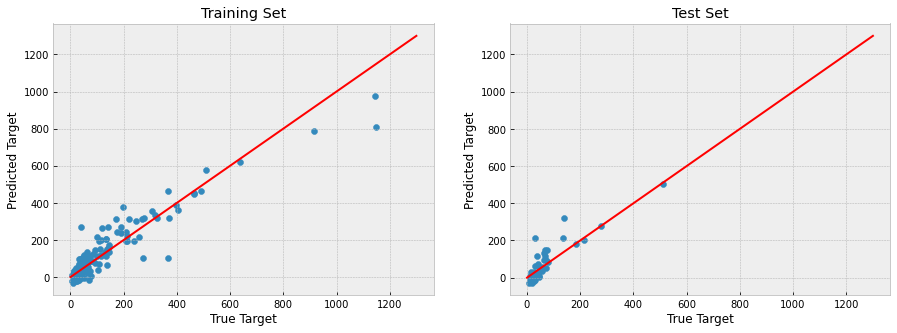

In [9]:
xline = np.linspace(0,1300,1301)

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.scatter(t_train, y_train); plt.plot(xline, xline, 'r')
plt.title('Training Set'); plt.xlabel('True Target'); plt.ylabel('Predicted Target')
plt.subplot(1,2,2)
plt.scatter(t_test, y_test); plt.plot(xline, xline, 'r')
plt.title('Test Set'); plt.xlabel('True Target'); plt.ylabel('Predicted Target');

5. **(3 points) Visualize the final weight coefficients. Which feature contributes the most to predict the target value?**

[-53.68214876  69.21654957 536.94911234 321.42972676 170.93338702
 -54.71765048 332.24481976]


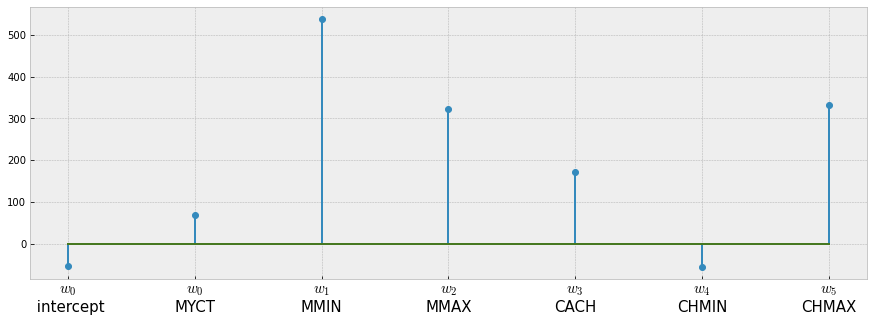

In [10]:
#Creating a vector will all the coefficients
coefs = np.hstack((final_model.named_steps['LR'].intercept_,
                  final_model.named_steps['LR'].coef_))
print(coefs)

plt.figure(figsize=(15,5))
plt.stem(coefs)
plt.xticks(range(len(coefs)),['$w_0$\n intercept']+
           ['$w_{'+str(x)+'}$\n'+df_hardware.columns[x] for x in range(0,len(coefs)-1)], size=15);

The feature minimum main memory in kilobytes (MMIN) has a larger magnitude weight contribution to the target variable and minimum channels in units (CHMIN) has the smallest contribution.

---

# Question 9 (15 points)

**In this problem, you will be working with the Mushroom dataset (please download it [here](https://ufl.instructure.com/files/69563261/download?download_frd=1)).**

> **This dataset includes descriptions of hypothetical samples corresponding to 23 species of gilled mushrooms in the Agaricus and Lepiota Family. Each species is identified as edible (```Target=1```) or poisonous/not recommended (```Target=0```).**

In [11]:
import pandas as pd

df_mushroom = pd.read_csv('mushroom-dataset.csv')
df_mushroom

,Target,Cap Shape,Cap Surface,Cap Color,Bruises?,Odor,Gill Attachment,Gill Spacing,Gill Size,Gill Color,...,Stalk Surface Below Ring,Stalk Color Above Ring,Stalk Color Below Ring,Veil Type,Veil Color,Ring Number,Ring Type,Spore Print Color,Population,Habitat
0,0,2,3,0,1,7,1,0,1,0,...,3,7,7,0,2,1,5,0,3,4
1,1,2,3,9,1,0,1,0,0,0,...,3,7,7,0,2,1,5,1,2,0
2,1,0,3,8,1,1,1,0,0,1,...,3,7,7,0,2,1,5,1,2,2
3,0,2,2,8,1,7,1,0,1,1,...,3,7,7,0,2,1,5,0,3,4
4,1,2,3,3,0,6,1,1,0,0,...,3,7,7,0,2,1,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8119,1,4,3,0,0,6,0,0,0,11,...,3,4,4,0,1,1,5,2,1,1
8120,1,2,3,0,0,6,0,0,0,11,...,3,4,4,0,0,1,5,2,4,1
8121,1,3,3,0,0,6,0,0,0,1,...,3,4,4,0,1,1,5,2,1,1
8122,0,4,2,0,0,3,1,0,1,2,...,2,7,7,0,2,1,1,7,4,1


In [12]:
X = df_mushroom[df_mushroom.columns[1:]].to_numpy()
t = df_mushroom[df_mushroom.columns[0]].to_numpy()

X.shape, t.shape

((8124, 22), (8124,))

**Answer the following questions:**

1. **(2 points) Split the data into training and test sets using 80/20 split.**

In [13]:
X_train, X_test, t_train, t_test = train_test_split(X, t, test_size=0.2, shuffle=True, stratify=t)

X_train.shape, t_train.shape, X_test.shape, t_test.shape

((6499, 22), (6499,), (1625, 22), (1625,))

2. **(11 points) Suppose you want to train a random forest classifier on this dataset. Build a ```scikit-learn``` pipeline to carry the experimental design on its parameters (number of trees and maximum depth for each tree) with a 4-fold stratified cross-validation scheme and the F1-score as the performance measure. Be sure to include all steps when building the model pipeline.**

**(Note: the grid search does not have to be exhaustive but illustrative enough to show that you know how to utilize the different ```scikit-learn``` objects. A total of 4 or 5 options for each parameter suffices.)**

In [14]:
# Pipeline
pipe = Pipeline(steps=[('Scaling', MinMaxScaler()),
                      ('RF', RandomForestClassifier())])

# 4-fold Stratified Cross-Validation
cv = StratifiedKFold(n_splits=4, shuffle=True)

# Parameter Grid Search
param_grid = dict(RF__n_estimators=[200,250,300, 350],
                  RF__max_depth=['None',3,4,5,6,10])
grid_search = GridSearchCV(pipe, param_grid, scoring='f1', cv=cv)

# Perform Experimental Design
grid_search.fit(X_train, t_train)
print(grid_search.best_params_)

{'RF__max_depth': 6, 'RF__n_estimators': 200}


In [15]:
# Training final model
final_model = grid_search.best_estimator_

final_model

Pipeline(steps=[('Scaling', MinMaxScaler()),
                ('RF', RandomForestClassifier(max_depth=6, n_estimators=200))])

In [16]:
# Predicting labels for training/test sets
y_train = final_model.predict(X_train)
y_test = final_model.predict(X_test)

3. **(4 points) Report the final model's performance with the accuracy report and confusion matrices. Discuss your observations (using a ```markdown``` cell), namely whether or not the final performance is indicative of overfitting.**

In [17]:
print('Training Set \n Classification Report:')
print(classification_report(t_train, y_train))
print('\n Confusion Matrix: ')
print(confusion_matrix(t_train, y_train))
print('\n\n ======== \n\n Test Set \n Classification Report')
print(classification_report(t_test, y_test))
print('\n Confusion Matrix:')
print(confusion_matrix(t_test, y_test))

Training Set 
 Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3133
           1       1.00      1.00      1.00      3366

    accuracy                           1.00      6499
   macro avg       1.00      1.00      1.00      6499
weighted avg       1.00      1.00      1.00      6499


 Confusion Matrix: 
[[3133    0]
 [   0 3366]]



 Test Set 
 Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       783
           1       1.00      1.00      1.00       842

    accuracy                           1.00      1625
   macro avg       1.00      1.00      1.00      1625
weighted avg       1.00      1.00      1.00      1625


 Confusion Matrix:
[[783   0]
 [  0 842]]


The model performs at 100% for both training and test sets. 

---

# Question 10 (20 points)

**In this problem, you will be working with the digits dataset:**

In [18]:
from sklearn.datasets import load_digits

digits = load_digits(return_X_y=False)

print(digits.DESCR)

.. _digits_dataset:

Optical recognition of handwritten digits dataset
--------------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 1797
    :Number of Attributes: 64
    :Attribute Information: 8x8 image of integer pixels in the range 0..16.
    :Missing Attribute Values: None
    :Creator: E. Alpaydin (alpaydin '@' boun.edu.tr)
    :Date: July; 1998

This is a copy of the test set of the UCI ML hand-written digits datasets
https://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits

The data set contains images of hand-written digits: 10 classes where
each class refers to a digit.

Preprocessing programs made available by NIST were used to extract
normalized bitmaps of handwritten digits from a preprinted form. From a
total of 43 people, 30 contributed to the training set and different 13
to the test set. 32x32 bitmaps are divided into nonoverlapping blocks of
4x4 and the number of on pixels are counted in each blo

In [19]:
# Loading data into feature matrix and target vector
X = digits.data

t = digits.target

X.shape, t.shape

((1797, 64), (1797,))

In [20]:
np.unique(t)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

**Answer the following questions:**

1. **(2 points) Partition the dataset into training/test with random stratification using a 70/30 split.**

In [21]:
X_train, X_test, t_train, t_test = train_test_split(X, t, test_size=0.3, shuffle=True, stratify=t)

X_train.shape, X_test.shape, t_train.shape, t_test.shape

((1257, 64), (540, 64), (1257,), (540,))

2. **(8 points) Perform dimensionality reduction with PCA and LDA. Justify all choices. (Be sure to applied any needed preprocessing.)**

In [22]:
# Feature Scaling
scaler = MinMaxScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

We need  22 PCs in order to explain at least 90% of the variance in the data


((1257, 22), (540, 22))

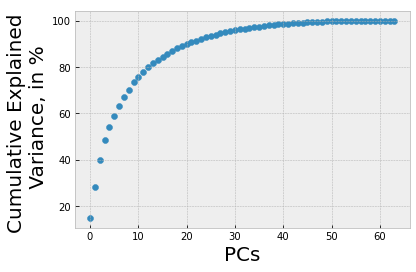

In [23]:
pca = PCA(n_components=64)
pca.fit(X_train)
plt.scatter(range(64), 100*np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('PCs', size=20)
plt.ylabel('Cumulative Explained \n Variance, in %', size=20);

num_PCs = np.where(np.cumsum(pca.explained_variance_ratio_)>=0.9)[0][0]
print('We need ', num_PCs +1,
     'PCs in order to explain at least 90% of the variance in the data')

final_pca = PCA(n_components=num_PCs+1).fit(X_train)
X_train_pca = final_pca.transform(X_train)
X_test_pca = final_pca.transform(X_test)

X_train_pca.shape, X_test_pca.shape

We need  6 LDA projections in order to explain at 90% of the data


((1257, 6), (540, 6))

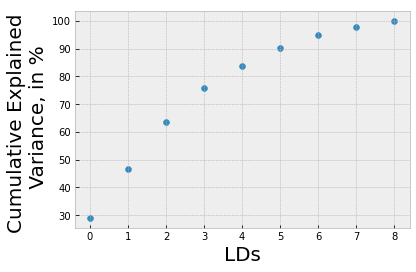

In [24]:
lda = LDA(n_components=9)
lda.fit(X_train, t_train)
plt.scatter(range(9), 100*np.cumsum(lda.explained_variance_ratio_))
plt.xlabel('LDs', size=20)
plt.ylabel('Cumulative Explained \n Variance, in %', size=20);

num_LDs = np.where(np.cumsum(lda.explained_variance_ratio_)>=0.9)[0][0]
print('We need ', num_LDs +1,
     'LDA projections in order to explain at 90% of the data')

final_lda = LDA(n_components=num_LDs+1).fit(X_train, t_train)
X_train_lda = final_lda.transform(X_train)
X_test_lda = final_lda.transform(X_test)

X_train_lda.shape, X_test_lda.shape

3. **(8 points) Implement the K-Nearest Neighbor (KNN) classifier on the PCA features and another KNN classifier on the LDA features. For each model, carry the complete experimental design to optimize for its hyperparameters (number of neighbors and type of ```weights```) using a 3-fold Stratified cross-validation scheme and the accuracy score as the performance measure.**

In [25]:
knn_pca = Pipeline(steps=[('Scaling',MinMaxScaler()),
                         ('PCA', PCA(n_components=num_PCs)),
                         ('KNN', KNeighborsClassifier())])

cv = StratifiedKFold(n_splits=3, shuffle=True)

param_grid = dict(KNN__n_neighbors=np.arange(5,30),
                 KNN__weights=['uniform', 'distance'])

grid_search = GridSearchCV(knn_pca, param_grid, cv=cv, scoring='accuracy')
grid_search.fit(X_train, t_train)

print(grid_search.best_params_)

final_knn_pca = grid_search.best_estimator_
y_train_pca = final_knn_pca.predict(X_train)
y_test_pca  = final_knn_pca.predict(X_test)

{'KNN__n_neighbors': 5, 'KNN__weights': 'distance'}


In [26]:
knn_lda = Pipeline(steps=[('Scaling',MinMaxScaler()),
                         ('LDA', LDA(n_components=num_LDs)),
                         ('KNN', KNeighborsClassifier())])

cv = StratifiedKFold(n_splits=3, shuffle=True)

param_grid = dict(KNN__n_neighbors=np.arange(5,30),
                 KNN__weights=['uniform', 'distance'])

grid_search = GridSearchCV(knn_lda, param_grid, cv=cv, scoring='accuracy')
grid_search.fit(X_train, t_train)

print(grid_search.best_params_)

final_knn_lda = grid_search.best_estimator_
y_train_lda = final_knn_lda.predict(X_train)
y_test_lda  = final_knn_lda.predict(X_test)

{'KNN__n_neighbors': 10, 'KNN__weights': 'distance'}


4. **(2 points) Report the performance for each classifier. Which model performs the best? Discussion your observations.**

In [27]:
print('PCA FEATURES')
print('Training Set \n Classification Report:')
print(classification_report(t_train, y_train_pca))
print('\n Confusion Matrix: ')
print(confusion_matrix(t_train, y_train_pca))
print('\n\n ======== \n\n Test Set \n Classification Report')
print(classification_report(t_test, y_test_pca))
print('\n Confusion Matrix:')
print(confusion_matrix(t_test, y_test_pca))

PCA FEATURES
Training Set 
 Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       124
           1       1.00      1.00      1.00       127
           2       1.00      1.00      1.00       124
           3       1.00      1.00      1.00       128
           4       1.00      1.00      1.00       127
           5       1.00      1.00      1.00       127
           6       1.00      1.00      1.00       127
           7       1.00      1.00      1.00       125
           8       1.00      1.00      1.00       122
           9       1.00      1.00      1.00       126

    accuracy                           1.00      1257
   macro avg       1.00      1.00      1.00      1257
weighted avg       1.00      1.00      1.00      1257


 Confusion Matrix: 
[[124   0   0   0   0   0   0   0   0   0]
 [  0 127   0   0   0   0   0   0   0   0]
 [  0   0 124   0   0   0   0   0   0   0]
 [  0   0   0 128   0   0   0   0   0   

In [28]:
print('LDA FEATURES')
print('Training Set \n Classification Report:')
print(classification_report(t_train, y_train_lda))
print('\n Confusion Matrix: ')
print(confusion_matrix(t_train, y_train_lda))
print('\n\n ======== \n\n Test Set \n Classification Report')
print(classification_report(t_test, y_test_lda))
print('\n Confusion Matrix:')
print(confusion_matrix(t_test, y_test_lda))

LDA FEATURES
Training Set 
 Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       124
           1       1.00      1.00      1.00       127
           2       1.00      1.00      1.00       124
           3       1.00      1.00      1.00       128
           4       1.00      1.00      1.00       127
           5       1.00      1.00      1.00       127
           6       1.00      1.00      1.00       127
           7       1.00      1.00      1.00       125
           8       1.00      1.00      1.00       122
           9       1.00      1.00      1.00       126

    accuracy                           1.00      1257
   macro avg       1.00      1.00      1.00      1257
weighted avg       1.00      1.00      1.00      1257


 Confusion Matrix: 
[[124   0   0   0   0   0   0   0   0   0]
 [  0 127   0   0   0   0   0   0   0   0]
 [  0   0 124   0   0   0   0   0   0   0]
 [  0   0   0 128   0   0   0   0   0   

PCA features have produced a better performance with the KNN classifier as indicated in the overall accuracy and confusion matrices.

---